# Comparsion Network Implementation

We would like to research how these different network architectures can accelerate queries and if it demonstrates a potential for speeding up computer graphic queries like bounding, ray intersection tests.

1. one MLP for one image
2. two MLP for one image, split is fixed
3. two MLP for one image, best split is randomly found out of n random tries
4. two MLP for one image, best split is result of clasifcying space using a network (~MoE)

Load dependencies

In [5]:
import jax
import jax.numpy as jnp
import optax
import IPython as ip
import matplotlib.pyplot as plt
from jax import random, grad, jit

Load image and define image sampling function for training

Image intensity range: 0.0 to 1.0
Example sampling: (Array([[0.37528604, 0.16666667],
       [0.08466819, 0.37356323],
       [0.19450802, 0.5373563 ]], dtype=float32), Array([[0.05490196, 0.34901962, 0.5764706 ],
       [0.01960784, 0.3647059 , 0.60784316],
       [0.24705882, 0.73333335, 0.91764706]], dtype=float32))


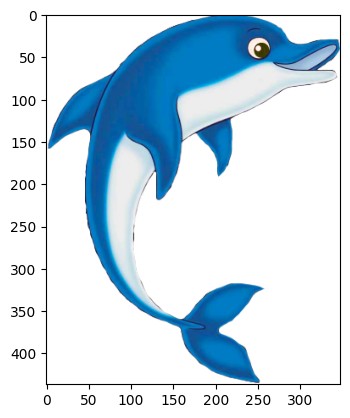

In [13]:
# Initialize random key
key = random.PRNGKey(28)

# Load and preview image normalized
# Separate color and alpha channel
img_rgba = jnp.array(plt.imread("dolphin_color.png"))
colors, mask = img_rgba[...,0:3], img_rgba[...,3].astype(bool)

# Define function to sample non transparent region of image
# when learning image
def sample_img(colors, mask, n_samples, key):
    
    # Extract n non-masked pixel coordinates (x) and colors (y)
    p_x, p_y = jnp.meshgrid(jnp.arange(img_rgba.shape[0]),jnp.arange(img_rgba.shape[1]), indexing='ij')
    p_x = jnp.stack((p_x, p_y),axis=-1)[mask]
    x = p_x[random.choice(random.split(key)[1], p_x.shape[0], (n_samples,))]
    y = colors[x[...,0], x[...,1]]
    x = x.at[...,0].divide(img_rgba.shape[0])
    x = x.at[...,1].divide(img_rgba.shape[1])

    return x, y

# Validate and display
print(f"Image intensity range: {jnp.min(img_rgba)} to {jnp.max(img_rgba)}")
plt.imshow(img_rgba)
print(f"Example sampling: {sample_img(colors,mask, 3, key)}")

Add helper functions

In [60]:
# Initalize parameters of network (weights and biases)
def init_mlp(layer_dims, key):
    p = []
    keys = random.split(key, len(layer_dims))
    for k, (n_in, n_out) in zip(keys, zip(layer_dims[:-1], layer_dims[1:])):
        W = random.normal(k, (n_in, n_out)) * 0.1
        b = jnp.zeros((n_out,))
        p.append((W, b))
    return p

# Predict with model
def forward(p, x):
    for W, b in p:
        x = jax.nn.relu(jnp.dot(x, W) + b)
    return x

# Mean squared error loss function
def loss(p, x, y):
    preds = jax.vmap(lambda x: forward(p, x))(x)
    return jnp.mean((preds - y) ** 2)

# Display image comparison between learned and original
def display_comparison(p):
    # Generate full predicted image
    H, W, C = colors.shape
    coords = jnp.indices((H, W)).reshape(2,-1).T
    coords = coords.at[...,0].divide(W)
    coords = coords.at[...,1].divide(H)
    pred_colors = jnp.clip(jax.vmap(lambda x: forward(p, x))(coords).reshape(H, W, C),0,1)

    # Display original and predicted image
    ip.display.clear_output(wait=True)
    fig, ax = plt.subplots(1, 3, figsize=(8, 4))
    ax[0].imshow(img_rgba)
    ax[0].set_title("Original")
    ax[1].imshow(pred_colors)
    ax[1].set_title("Predicted")
    ax[2].imshow(jnp.concat([pred_colors, jnp.expand_dims(mask,axis=-1)], axis=-1))
    ax[2].set_title("Predicted Masked")
    for a in ax:
        a.axis("off")
    plt.tight_layout()
    plt.show()


### #1 - MLP for one image
Fit a single MLP to an image.

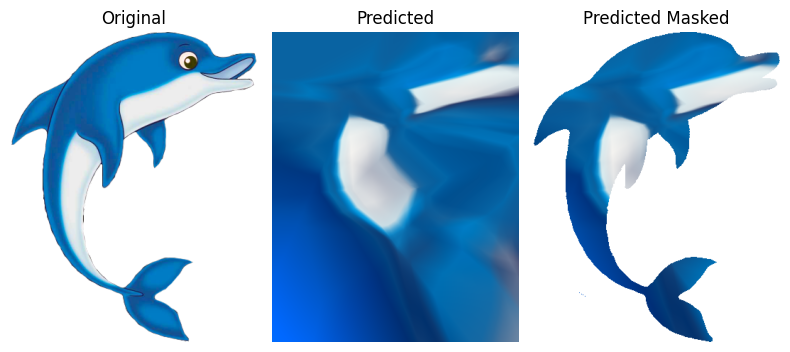

In [61]:
# Hyperparameter
p = init_mlp([2, 16, 64, 128, 256, 128, 64, 16, 3], key)
opt = optax.adam(learning_rate=0.01)
opt_state = opt.init(p)
num_epochs = 1000
batch_size = 1024

# Just in time compiled update function for speed up training
@jit
def update(p, opt_state, x, y):
    grads = grad(loss)(p, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state

# Training loop
for epoch in range(num_epochs):
    x, y = sample_img(colors, mask, batch_size,key)
    p, opt_state = update(p, opt_state, x, y)
    if epoch % 100 == 0:
        ip.display.clear_output(wait=True)
        print(f"Epoch {epoch}, Loss: {loss(p, x, y)}")
display_comparison(p)